In [2]:
# importing a packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM ,Dense, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [3]:
# Defining a the sysmbol of TATA Steel from Yahoo finanace
tataSteel_symbol = 'TATASTEEL.NS' #Example ='jiofin.ns'

# Fetching a live data of TATA Steel share
tataSteel_ticker = yf.Ticker(tataSteel_symbol)

# Get historical data of TATA steel last 10y data with a 1 day interval
tataSteel_DF = tataSteel_ticker.history(period='max', interval='1d')

# Sample of data
tataSteel_DF.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1996-01-01 00:00:00+05:30,2.434930,2.444107,2.404952,2.437989,10242229,0.0,0.0
1996-01-02 00:00:00+05:30,2.434931,2.444107,2.386599,2.392717,16954313,0.0,0.0
1996-01-03 00:00:00+05:30,2.392717,2.447167,2.386599,2.393329,13514114,0.0,0.0
1996-01-04 00:00:00+05:30,2.355397,2.355397,2.263628,2.317466,34785820,0.0,0.0
1996-01-05 00:00:00+05:30,2.289324,2.300336,2.248334,2.271582,30138033,0.0,0.0


In [4]:
def preProcessing(copyOfDataframe):
    '''
        Excluding divident and stock splits because it always zero
    '''
    copyOfDataframe = copyOfDataframe.drop(columns=['Dividends', 'Stock Splits'], errors='ignore')
    
    # Extrating a Number of year, month, week and day
    copyOfDataframe['Year']  = copyOfDataframe.index.year
    copyOfDataframe['Month'] = copyOfDataframe.index.month
    copyOfDataframe['Week']  = copyOfDataframe.index.day_of_week
    copyOfDataframe['Day']  = copyOfDataframe.index.day
    
    # Dropping a origal Date column
    copyOfDataframe = copyOfDataframe.reset_index(drop=True)
    
    # Drop row with missing values
    copyOfDataframe = copyOfDataframe.dropna()
    
    # Reordering a columns values 
    copyOfDataframe = copyOfDataframe[['Year', 'Month', 'Week','Day','Open','High','Low', 'Close', 'Volume']]
    
    return copyOfDataframe

In [5]:
tataSteel_DF = preProcessing(tataSteel_DF.copy())
tataSteel_DF

,Year,Month,Week,Day,Open,High,Low,Close,Volume
0,1996,1,0,1,2.434930,2.444107,2.404952,2.437989,10242229
1,1996,1,1,2,2.434931,2.444107,2.386599,2.392717,16954313
2,1996,1,2,3,2.392717,2.447167,2.386599,2.393329,13514114
3,1996,1,3,4,2.355397,2.355397,2.263628,2.317466,34785820
4,1996,1,4,5,2.289324,2.300336,2.248334,2.271582,30138033
...,...,...,...,...,...,...,...,...,...
7194,2024,8,3,22,152.509995,154.350006,152.509995,154.139999,36719176
7195,2024,8,4,23,154.000000,154.389999,152.550003,154.199997,31490857
7196,2024,8,0,26,154.610001,156.399994,153.699997,155.699997,32497603
7197,2024,8,1,27,155.800003,156.500000,154.600006,154.699997,24523684


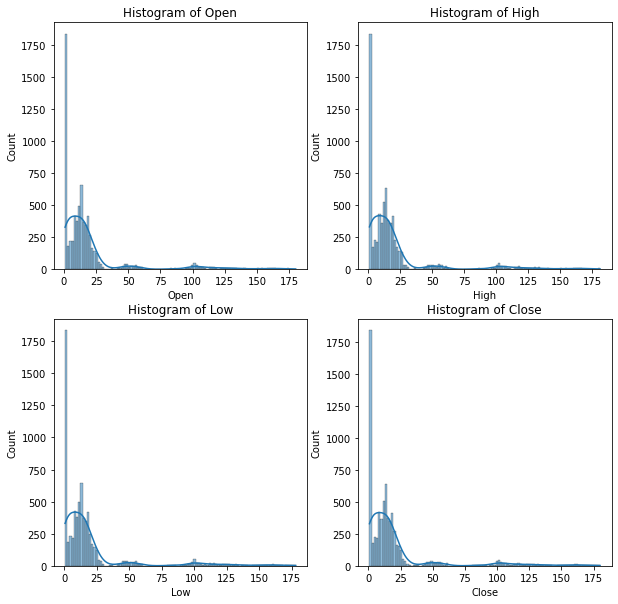

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for i, (colm, ax) in enumerate(zip(['Open','High','Low', 'Close','Volume'], ax.flatten())):
  sns.histplot(data=tataSteel_DF, x=colm, ax=ax, kde=True)
  ax.set_title(f'Histogram of {colm}')

In [7]:
# Normalization data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tataSteel_DF) # type: ignore

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # Create sequence of 'time_step' length
        y.append(data[i + time_step, 7])  # Predict the 'Close' price of the next time step
    return np.array(X), np.array(y)

time_step = 60  # Length of the time window
X, y = create_dataset(scaled_data, time_step)

In [8]:
# Splitting a data into Training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape Data for Neural Network
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

print('X_train  : ', X_train.shape)
print('X_test   : ', X_test.shape)
print('y_train  : ', y_train.shape)
print('y_test   : ', y_train.shape)

X_train  :  (5710, 60, 9)
X_test   :  (1428, 60, 9)
y_train  :  (5710,)
y_test   :  (5710,)


In [9]:
lstm_Model = Sequential()

# Layer one with Input Shape and Regulization
lstm_Model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_Model.add(Dropout(0.2))

# Second Layer with Regulization
lstm_Model.add(LSTM(100, return_sequences=True))
lstm_Model.add(Dropout(0.2))

# Third Layer with Regulization
lstm_Model.add(LSTM(50, return_sequences=False))
lstm_Model.add(Dropout(0.2))

lstm_Model.add(Dense(50, activation='relu'))

#Output Layer
lstm_Model.add(Dense(1))

lstm_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           44000     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2

In [10]:
# Compiling a Model
lstm_Model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = lstm_Model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
179/179 [==============================] - 36s 154ms/step - loss: 0.0024 - mean_absolute_error: 0.0247 - val_loss: 3.2964e-04 - val_mean_absolute_error: 0.0115
Epoch 2/50
179/179 [==============================] - 28s 154ms/step - loss: 8.4700e-04 - mean_absolute_error: 0.0167 - val_loss: 2.7404e-04 - val_mean_absolute_error: 0.0104
Epoch 3/50
179/179 [==============================] - 26s 144ms/step - loss: 6.3128e-04 - mean_absolute_error: 0.0148 - val_loss: 3.1300e-04 - val_mean_absolute_error: 0.0087
Epoch 4/50
179/179 [==============================] - 28s 158ms/step - loss: 6.5585e-04 - mean_absolute_error: 0.0137 - val_loss: 5.9618e-04 - val_mean_absolute_error: 0.0111
Epoch 5/50
179/179 [==============================] - 29s 161ms/step - loss: 5.1039e-04 - mean_absolute_error: 0.0122 - val_loss: 3.3091e-04 - val_mean_absolute_error: 0.0130
Epoch 6/50
179/179 [==============================] - 30s 166ms/step - loss: 5.4338e-04 - mean_absolute_error: 0.0134 - val_loss:

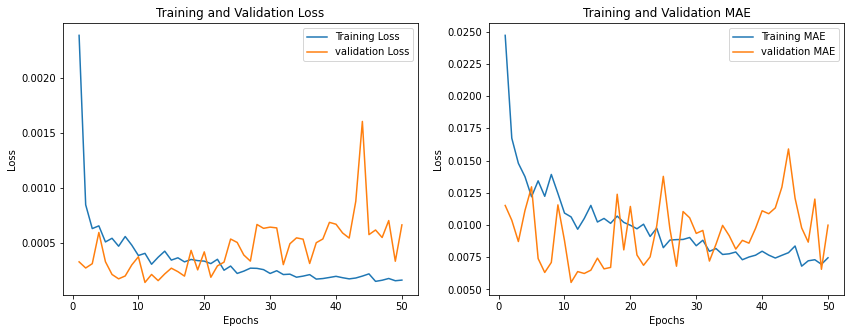

In [15]:
# assigning a 50 epochs
epochs = list(range(1,51))

# initialize figure size
plt.figure(figsize=(14,5))

# Plotting a Training and validation Loss
plt.subplot(1,2,1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting a Mean Absolute Error
plt.subplot(1,2,2)
plt.plot(epochs, history.history['mean_absolute_error'], label='Training MAE')
plt.plot(epochs, history.history['val_mean_absolute_error'], label='validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [13]:
# Make Predictions
predictions = lstm_Model.predict(X_test)

#Inverse Transform Predictions
predictions = scaler.inverse_transform(np.hstack((np.zeros((predictions.shape[0], tataSteel_DF.shape[1] - 1)), predictions)))

# Extract the closing price predictions
predictions = predictions[:, -1]

# Evaluate the Model
mse = mean_squared_error(scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], tataSteel_DF.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1], predictions)
print(f'Mean Squared Error: {mse}')

# Round predictions to 2 decimal points
predictions = np.round(predictions, 2)
print(predictions[:10])

45/45 [==============================] - 4s 45ms/step
Mean Squared Error: 274726851824532.25
[33638240.18 33500257.29  4235750.02 62080370.09 40427205.33  1548860.23
  1694003.53 59153800.35 57460163.21 27098910.13]


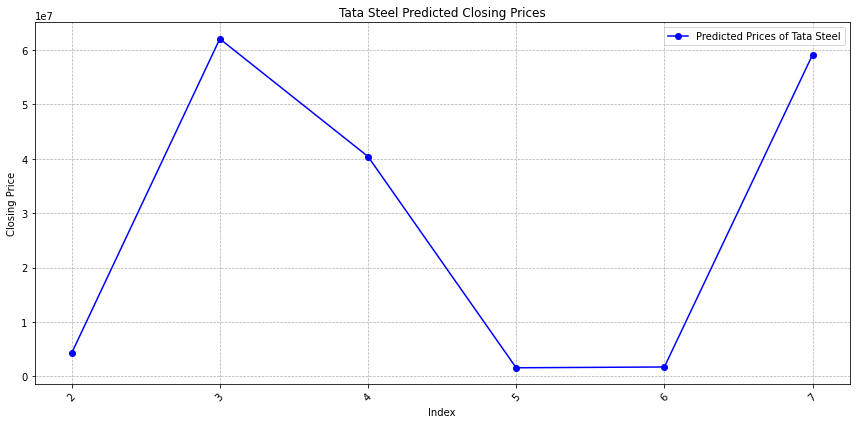

In [14]:
# Selecting specific range of index for clear ploting
start_index = 2
end_index = 7
tataSteel_DF_x = np.arange(start_index, end_index + 1)
tatasteel_predictions = predictions[start_index:end_index + 1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tataSteel_DF_x, tatasteel_predictions, marker='o', linestyle='-', color='b', label='Predicted Prices of Tata Steel')

plt.title('Tata Steel Predicted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()